# Test mini_tVAE

### 1. Setup

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mfacotti/martin/tVAE_project')
from mini_tvae import MiniTVAE

### 2. Load data

In [3]:
def load_rhc_data():
    """Load the RHC dataset and metadata."""
    try:
        # Load the CSV file
        data = pd.read_csv('../rhc.csv')
        
        # Load the metadata file
        with open('../metadata.json', 'r') as f:
            metadata = json.load(f)
            
        # Extract discrete columns from metadata
        discrete_columns = []
        for column, info in metadata.get('columns', {}).items():
            if info.get('type') == 'categorical' or info.get('sdtype') == 'categorical':
                discrete_columns.append(column)
                
        # If no discrete columns found in metadata, try to infer them
        if not discrete_columns:
            print("No discrete columns found in metadata. Inferring from data types...")
            for col in data.columns:
                if data[col].dtype == 'object' or data[col].dtype == 'category':
                    discrete_columns.append(col)
        
        print(f"Loaded RHC dataset with {data.shape[0]} rows and {data.shape[1]} columns")
        print(f"Identified {len(discrete_columns)} discrete columns")
        
        return data, discrete_columns
        
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        exit(1)

data, discrete_columns = load_rhc_data()

No discrete columns found in metadata. Inferring from data types...
Loaded RHC dataset with 5735 rows and 63 columns
Identified 21 discrete columns


### 3. Data preprocessing

In [4]:
# First approach
def clean_data(data):
    """Basic data cleaning and handling missing values."""
    # Handle missing values
    for column in data.columns:
        if data[column].dtype == 'object' or data[column].dtype == 'category':
            # For categorical columns, fill with the most frequent value
            mode_value = data[column].mode()[0]
            data[column] = data[column].fillna(mode_value)
        else:
            # For numerical columns, fill with the median
            data[column] = data[column].fillna(data[column].median())
    
    return data


data = clean_data(data)
data.head()

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,MOSF w/Sepsis,Yes,11142,11151.0,11831.5,11382,No,0,...,No,No,No,No,No,0.0,1927.0,white,Under $11k,5
1,2,MOSF w/Sepsis,MOSF w/Sepsis,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,0.0,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,11831.5,12400,No,0,...,No,No,No,No,No,0.0,599.0,white,$25-$50k,9
3,4,ARF,MOSF w/Sepsis,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,0.0,1927.0,white,$11-$25k,10
4,5,MOSF w/Sepsis,MOSF w/Sepsis,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,0.0,64.0,white,Under $11k,11


### 4. Training

In [5]:
def train_tvae_model(data, discrete_columns, hyperparams=None):
    """
    Create and train a MiniTVAE model with the provided hyperparameters.
    
    Parameters:
    -----------
    data : DataFrame
        The training data
    discrete_columns : list
        List of discrete/categorical columns
    hyperparams : dict, optional
        Dictionary of hyperparameters for the MiniTVAE model
        
    Returns:
    --------
    MiniTVAE
        The trained model
    """
    # Default hyperparameters
    default_params = {
        'embedding_dim': 128,
        'compress_dims': (128, 128),
        'decompress_dims': (128, 128),
        'l2scale': 1e-5,
        'batch_size': 500,
        'epochs': 500,
        'loss_factor': 2,
        'cuda': True, # Set to False if running on CPU
        'verbose': True
    }
    
    # Use provided hyperparameters or default values
    params = default_params.copy()
    if hyperparams:
        params.update(hyperparams)
    
    print("Training Mini TVAE model with the following parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Create and train the model
    model = MiniTVAE(**params)
    model.fit(data, discrete_columns)
    
    return model

model = train_tvae_model(data, discrete_columns)

Training Mini TVAE model with the following parameters:
  embedding_dim: 128
  compress_dims: (128, 128)
  decompress_dims: (128, 128)
  l2scale: 1e-05
  batch_size: 500
  epochs: 500
  loss_factor: 2
  cuda: True
  verbose: True


/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate dat

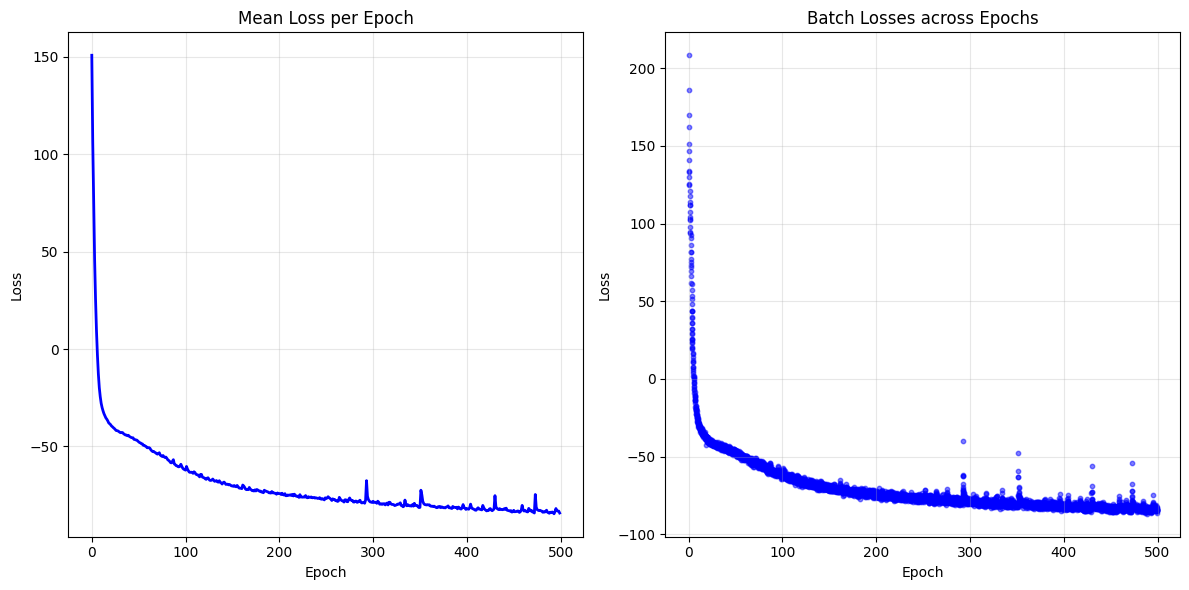

In [19]:
def plot_loss_over_epochs(loss_values):
    """Plot the loss function across epochs."""
    # Group by epoch and calculate mean loss per epoch
    epoch_loss = loss_values.groupby('Epoch')['Loss'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    
    # Plot mean loss per epoch
    plt.subplot(1, 2, 1)
    plt.plot(epoch_loss['Epoch'], epoch_loss['Loss'], 'b-', linewidth=2)
    plt.title('Mean Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot all batch losses across epochs
    plt.subplot(1, 2, 2)
    for epoch in sorted(loss_values['Epoch'].unique()):
        epoch_data = loss_values[loss_values['Epoch'] == epoch]
        plt.scatter([epoch] * len(epoch_data), epoch_data['Loss'], 
                   alpha=0.5, s=10, color='blue')
    
    plt.title('Batch Losses across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig('tvae_loss_curves.png')
    # print("Loss curves saved to 'tvae_loss_curves.png'")
    # plt.close()

    plt.show()

plot_loss_over_epochs(model.loss_values)

In [7]:
print(model.loss_values.columns)

Index(['Epoch', 'Batch', 'Loss'], dtype='object')


### 5. Generation

In [ ]:
def generate_synthetic_data(model, num_samples, save_path=None):
    """
    Generate synthetic data from the trained model.
    
    Parameters:
    -----------
    model : MiniTVAE
        The trained model
    num_samples : int
        Number of samples to generate
    save_path : str, optional
        Path to save the synthetic data
        
    Returns:
    --------
    DataFrame
        The generated synthetic data
    """
    print(f"Generating {num_samples} synthetic samples...")
    synthetic_data = model.sample(num_samples)
    
    if save_path:
        synthetic_data.to_csv(save_path, index=False)
        print(f"Synthetic data saved to '{save_path}'")
    
    return synthetic_data

# Complete usage example
# def run_full_example():
#     # Load data
#     data, discrete_columns = load_rhc_data()
#     if data is None:
#         return
#     
#     # Display information about the data
#     print("\nData sample:")
#     print(data.head())
#     print("\nData types:")
#     print(data.dtypes)
#     
#     # Clean the data
#     data = clean_data(data)
#     
#     # Custom hyperparameters (example)
#     custom_params = {
#         'embedding_dim': 128,
#         'batch_size': 500,
#         'epochs': 500,
#         'cuda': True
#     }
#     
#     # Train the model
#     model = train_tvae_model(data, discrete_columns, custom_params)
#     
#     # Generate synthetic data
#     synthetic_data = generate_synthetic_data(model, len(data), 'synthetic_rhc.csv')
#     
#     # Compare statistics
#     compare_statistics(data, synthetic_data, discrete_columns)
#     
#     # Visualize losses
#     plot_loss_over_epochs(model.loss_values, 'tvae_loss_curves.png')
#     
#     return model, data, synthetic_data

In [ ]:
def compare_statistics(original_data, synthetic_data, discrete_columns, 
                       num_numeric=5, num_categorical=3, num_categories=5):
    """
    Compare statistics between original and synthetic data.
    
    Parameters:
    -----------
    original_data : DataFrame
        The original data
    synthetic_data : DataFrame
        The synthetic data
    discrete_columns : list
        List of discrete/categorical columns
    num_numeric : int, optional
        Number of numeric columns to compare
    num_categorical : int, optional
        Number of categorical columns to compare
    num_categories : int, optional
        Number of categories to display per categorical column
    """
    print("Comparing statistics between original and synthetic data:")
    
    # Compare numeric columns
    numeric_columns = original_data.select_dtypes(include=['number']).columns
    if len(numeric_columns) > 0:
        print("\nNumeric columns comparison:")
        for col in numeric_columns[:num_numeric]:
            orig_mean = original_data[col].mean()
            orig_std = original_data[col].std()
            syn_mean = synthetic_data[col].mean()
            syn_std = synthetic_data[col].std()
            
            print(f"\nColumn: {col}")
            print(f"  Original - Mean: {orig_mean:.4f}, Std: {orig_std:.4f}")
            print(f"  Synthetic - Mean: {syn_mean:.4f}, Std: {syn_std:.4f}")
            print(f"  Difference - Mean: {abs(orig_mean-syn_mean):.4f}, Std: {abs(orig_std-syn_std):.4f}")
    
    # Compare categorical columns
    if len(discrete_columns) > 0:
        print("\nCategorical columns comparison (value counts percentage):")
        for col in discrete_columns[:num_categorical]:
            print(f"\nColumn: {col}")
            orig_counts = original_data[col].value_counts(normalize=True).sort_index()
            syn_counts = synthetic_data[col].value_counts(normalize=True).sort_index()
            
            # Combine indices to ensure we show all categories
            all_cats = sorted(list(set(list(orig_counts.index) + list(syn_counts.index))))
            
            for cat in all_cats[:num_categories]:
                orig_pct = orig_counts.get(cat, 0) * 100
                syn_pct = syn_counts.get(cat, 0) * 100
                print(f"  {cat}: Original {orig_pct:.1f}%, Synthetic {syn_pct:.1f}%, Diff {abs(orig_pct-syn_pct):.1f}%")